# Unit 02 Project: Curve Fitting/Modeling Rocket Thrust

## Purpose/Abstract

The purpose of this notebook is to create a function to calculate the Thrust of a rocket at any given time step through curve fitting the data given. After that I will use derivatives and ODE solvers to model the rocket's thrust.

## Theoretical Model

The formula below is referenced from the research project of Elizabeth Messina and Dr. Aaron Titus about Accunting for Non Constant Thrust in a Model Rocket Simulator. The equation is used to curve fit the data given which will create a model function that will take a time and the curve fit paramters, and output the Thrust. 

<img src='equation.png' width='400'>

To use the ODE solvers you must first take the derivatives of the rockets position and velocity. Those derivaties are defined below:

$$\frac{dx}{dt} = v_x \qquad \frac{dy}{dt} = v_y \qquad \frac{dz}{dt} = v_z$$

$$\frac{d v_x}{dt} = \frac{F_{Thrust,x}*cos(theta)}{m} \qquad \frac{d v_y}{dt} = \frac{F_{Thrust,y}*sin(theta)*rocket_{m}*g}{m} \qquad \frac{d v_y}{dt} = {0}$$


## The Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import numpy as np
import ode
from vpython import *

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv('thrust-time-data.txt', sep='\t')
df.head()

,t (s),F (N)
0,0.00,0.521146
1,0.02,1.096904
2,0.04,1.854481
3,0.06,2.763573
4,0.08,4.218120


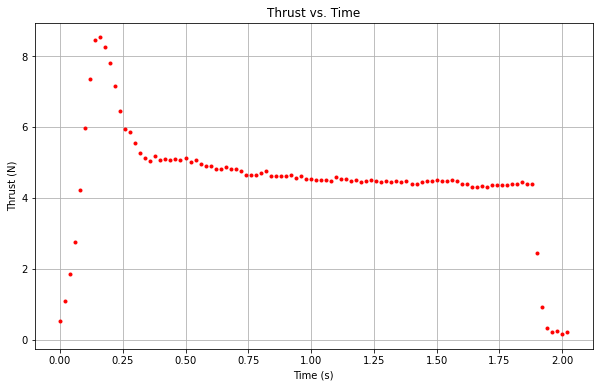

In [3]:
xData = df['t (s)']
yData = df['F (N)']

plt.figure(figsize=(10,6))
plt.plot(xData, yData, 'r.')
plt.title('Thrust vs. Time')
plt.ylabel('Thrust (N)')
plt.xlabel('Time (s)')
plt.grid()

/Users/atitus/opt/anaconda3/envs/phy2200/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


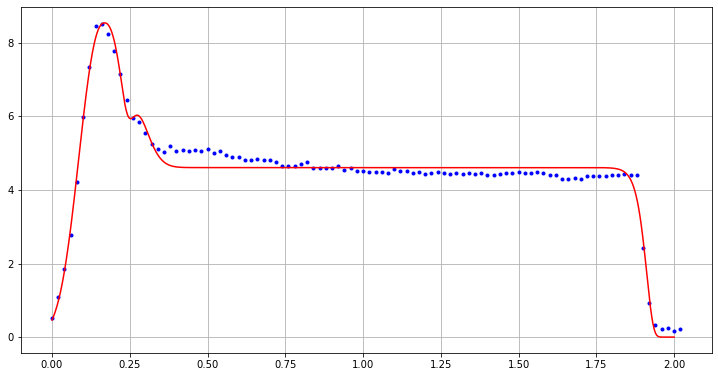

The sum of the squares of the residuals = 5.305317e+00
The curve fit parameters are: 8.545, 176.694, 0.169, 1.154, 4.610, 2010.013, 1.086, 19.941


In [5]:
model = lambda t,a1,k1,b1,m1,a2,k2,b2,m2: a1*np.exp(-k1*((t-b1)**2)**m1)+a2*np.exp(-k2*((t-b2)**2)**m2)

guess = [10,5,0.3,2,1,100,1,1]
params, stats = curve_fit(model, xData, yData, p0=guess)

# calculate points for the model
xmodel = np.linspace(0,2,1000)
ymodel = model(xmodel,*params)

# create graph
fig1 = plt.figure(figsize=(12,8))

# plot data and model
frame1=fig1.add_axes((.1,.3,.8,.6))
plt.plot(xData,yData,'.b') # data
plt.plot(xmodel,ymodel,'-r') # best fit model
plt.grid()
plt.show()

#results
residuals = model(xData,*params) - yData
print("The sum of the squares of the residuals = {:e}".format(np.sum(residuals**2)))
print("The curve fit parameters are: {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}".format(*params))

In [6]:
scene = canvas(title='Rocket')
scene.camera.pos = scene.camera.pos+vector(0, 20, -10)
scene.autoscale = True

rocket = box(pos=vector(0,11.5,0), size=vector(3, 3, 3), color=color.red)
rocket.m = .05
rocket.v = vec(0,0,0)

moon = sphere(pos=vec(0,0,0), radius=10, color=color.white)

g = 1.62
theta = 70*np.pi/180
t = 0
dt = 0.01

data = np.array([rocket.pos.x,rocket.pos.y,rocket.pos.z,rocket.v.x,rocket.v.y,rocket.v.z])

steps = 1000
traj = np.zeros((steps,7)) # t,x,y,z

def deriv(d,t):
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    rates = np.zeros(6)
    if t > 2: 
        Fthrust = 0
    else:
        Fthrust = model(t,*params)
    rates[0] = vx
    rates[1] = vy
    rates[2] = vz
    rates[3] = Fthrust*np.cos(theta)/rocket.m
    rates[4] = (Fthrust*np.sin(theta) - rocket.m * g)/rocket.m
    rates[5] = 0
    return rates

scene.pause()

for n in range(steps):
    rate(100)
    data = ode.RK4(deriv,data,t,dt)
    rocket.pos = vec(data[0],data[1],data[2])
    rocket.v = vec(data[3],data[4],data[5])
    
    t = t + dt
    
    traj[n,:] = np.array([t, data[0], data[1], data[2], data[3], data[4], data[5]])



<IPython.core.display.Javascript object>

[]

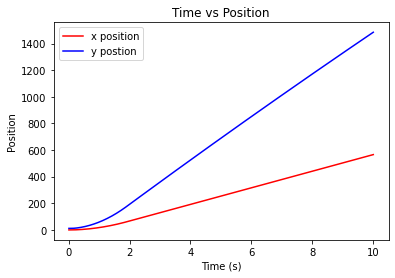

In [7]:
plt.plot(traj[:,0], traj[:,1], 'r', label='x position')
plt.plot(traj[:,0], traj[:,2], 'b', label='y postion')
plt.title('Time vs Position')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.plot()

[]

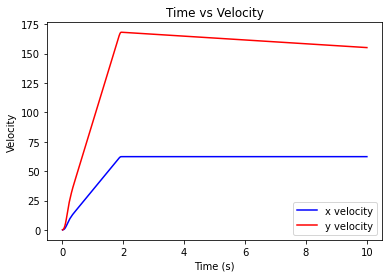

In [10]:
plt.plot(traj[:,0], traj[:,4], 'b', label='x velocity')
plt.plot(traj[:,0], traj[:,5], 'r', label='y velocity')
plt.title('Time vs Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend()
plt.plot()

## Validation

The above vypython model and graphs allow me to belive the model is indeed correct. You can see in both as time goes on the rocket is being thrust into space.

The second graph shows the rockets velocity increasing until time step of two seconds, which is where the thrusters are turned off. 

I was also able to validate the model by changing angle theta, which changes the direction in which the rocket will launch.